In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import ir_datasets as irds
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
import json
import re
from tqdm import tqdm
from transformers import AutoTokenizer
from langdetect import detect_langs
from language_tool_python import LanguageTool
from textstat import textstat
from functools import partial
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
from pyserini.search.lucene import LuceneSearcher
from pyserini.index.lucene import IndexReader
from collections import Counter
import math

tqdm.pandas()
nltk.download('punkt')
tokenizer = AutoTokenizer.from_pretrained("sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco")
stemmer = PorterStemmer()
tool = LanguageTool('en-US')
DL19 = r"msmarco-passage/trec-dl-2019/judged"
DL20 = r"msmarco-passage/trec-dl-2020/judged"
MSMARCO_DEV = r"msmarco-passage/dev/small"
device = 'cuda'
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id
model.eval();

[nltk_data] Downloading package punkt to
[nltk_data]     /home/eickhoff/esx208/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/scratch_local/esx208-1080396/ir_mech_interp/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


KeyboardInterrupt: 

In [2]:
searcher = LuceneSearcher.from_prebuilt_index('msmarco-v1-passage-slim')
reader = IndexReader.from_prebuilt_index('msmarco-v1-passage-slim')

Jan 23, 2025 1:39:37 PM org.apache.lucene.store.MMapDirectory lookupProvider


In [3]:
DL19_dataset = irds.load(DL19)
DL20_dataset = irds.load(DL20)
msmarco_dev = irds.load(MSMARCO_DEV)
queries_dl_19 = pd.DataFrame(DL19_dataset.queries_iter())
queries_dl_20 = pd.DataFrame(DL20_dataset.queries_iter())
queries_msmarco = pd.DataFrame(msmarco_dev.queries_iter())
queries = pd.concat([queries_dl_19, queries_dl_20, queries_msmarco], ignore_index=True).drop_duplicates(subset=['query_id'])

In [4]:
def tokenize_and_stem(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    processed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(processed_tokens)

def tokenize(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    return ' '.join(tokens)

In [5]:
queries['text_tokenized'] = queries['text'].progress_apply(tokenize)
queries['text_stemmed'] = queries['text'].progress_apply(tokenize_and_stem)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7077/7077 [00:01<00:00, 6844.06it/s]


In [22]:
def get_english_probability(text):
    eng_prob = 0.0
    try:
        lang_probs = detect_langs(text)
        for prob in lang_probs:
            if prob.lang == 'en':
                eng_prob = prob.prob
    except:
        pass
    return eng_prob


def get_grammar_score(text):
    matches = tool.check(text)
    word_count = len(text.split()) # this is not a good way to count words TODO improve
    error_count = len(matches)
    error_ratio = error_count / word_count
    return error_ratio


def get_tfidf(text, reader):
    terms = text.split()
    tf = Counter(terms)
    num_docs = reader.stats()['documents']
    
    tfidf_scores = []
    for term, term_count in tf.items():
        try:
            df = reader.get_term_counts(term)[0]
        except:
            df = 0
        if df > 0:
            tf = term_count / len(terms)
            idf = math.log(num_docs / df)
            tfidf_scores.append(tf * idf)
    return tfidf_scores


def get_tf_injected_term(text, term):
    terms = text.split()
    tf = Counter(terms)
    if term in tf:
        return tf[term]
    else:
        return 0


def get_tfidf_injected_term(text, term, reader):
    tfidf_scores = get_tfidf(text, reader)
    if term in tfidf_scores:
        return tfidf_scores[term]
    else:
        return 0


def get_mean_tfidf(text, reader):
    tfidf = get_tfidf(text, reader)
    return np.mean(tfidf) if tfidf else 0.0


def get_std_tfidf(text, reader):
    tfidf = get_tfidf(text, reader)
    return np.std(tfidf) if tfidf else 0.0


def get_readability_scores(text, score_type='flesch_reading_ease'):
    text = text.lower()
    # Replace multiple whitespace with single space
    text = re.sub(r'\s+', ' ', text)
    # Remove special characters but keep punctuation
    text = re.sub(r'[^\w\s.,!?;:\'\"\-]', '', text)
    
    return {
        'flesch_reading_ease': textstat.flesch_reading_ease(text),
        'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
        'gunning_fog': textstat.gunning_fog(text),
        'smog_index': textstat.smog_index(text),
        'coleman_liau_index': textstat.coleman_liau_index(text),
        'automated_readability_index': textstat.automated_readability_index(text),
        'dale_chall_readability_score': textstat.dale_chall_readability_score(text)
    }
    
    
def process_batch(texts, model, tokenizer, max_length=512):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, 
                       truncation=True, max_length=max_length)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids = input_ids, 
                        attention_mask = attention_mask)
        
        target_ids = input_ids[:, 1:]
        logits = outputs.logits[:, :-1, :]
        attention_mask = attention_mask[:, 1:]
        log_probs = torch.log_softmax(logits, dim=-1)

        batch_size, seq_length = target_ids.shape
        batch_indices = torch.arange(batch_size).unsqueeze(1).to(device)
        seq_indices = torch.arange(seq_length).unsqueeze(0).to(device)
        token_log_probs = log_probs[batch_indices, seq_indices, target_ids]
        
        cross_entropy = -torch.sum(token_log_probs * attention_mask, dim=1) / attention_mask.sum(dim=1)
        perplexity = torch.exp2(cross_entropy)
            
    return perplexity.cpu().numpy().tolist()


def calculate_gpt2_entropy_batch(df, text_column='text', batch_size=64):    
    entropies = []
    for i in tqdm(range(0, len(df), batch_size)):
        batch_texts = df[text_column].iloc[i:i+batch_size].tolist()
        batch_entropies = process_batch(batch_texts, model, tokenizer)
        entropies.extend(batch_entropies)
    
    return pd.Series(entropies, index=df.index, name='gpt2_entropy')


def compute_metrics(dataframe, reader):
    dataframe['tfidf_mean'] = dataframe['text_tokenized'].progress_apply(lambda x: get_mean_tfidf(x, reader))
    dataframe['tfidf_std'] = dataframe['text_tokenized'].progress_apply(lambda x: get_std_tfidf(x, reader))
    dataframe['doc_length'] = dataframe['text_tokenized'].apply(lambda x: len(x.split()))
    dataframe['english_probability'] = dataframe['text_tokenized'].progress_apply(get_english_probability)
    # dataframe['grammar_score'] = dataframe['text'].progress_apply(get_grammar_score)
    readability_scores = dataframe['text'].progress_apply(get_readability_scores)
    readability_df = pd.DataFrame(readability_scores.tolist(), index=readability_scores.index)
    dataframe = pd.concat([dataframe, readability_df], axis=1)
    dataframe['gpt2_perplexity'] = calculate_gpt2_entropy_batch(dataframe)
    return dataframe

In [23]:
queries_metrics = compute_metrics(queries.copy(), reader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 111/111 [00:04<00:00, 27.55it/s]


In [11]:
queries_metrics[queries_metrics['tfidf_mean'] > 5]

,query_id,text,text_tokenized,text_stemmed,tfidf_mean,doc_length,english_probability,flesch_reading_ease,flesch_kincaid_grade,gunning_fog,smog_index,coleman_liau_index,automated_readability_index,dale_chall_readability_score
492,537995,vittorio cottafavi,vittorio cottafavi,vittorio cottafavi,6.320481,2,0.0,35.61,8.8,20.8,0.0,18.70,19.6,19.53
1258,1085510,carewell urgent,carewell urgent,carewel urgent,5.353266,2,0.0,77.91,2.9,0.8,0.0,10.00,12.5,19.53
1501,1088884,wadi sirhan,wadi sirhan,wadi sirhan,5.725854,2,0.0,77.91,2.9,0.8,0.0,-1.61,3.1,19.53
1650,1090839,adam bossov,adam bossov,adam bossov,5.051173,2,0.0,120.21,-3.1,0.8,0.0,-1.61,3.1,19.53
2222,1098481,aultman orrville,aultman orrville,aultman orrvil,6.190586,2,0.0,35.61,8.8,0.8,0.0,12.90,14.9,19.53
2328,1100010,hemelse modder,hemelse modder,hemels modder,6.372931,2,0.0,77.91,2.9,0.8,0.0,7.10,10.2,19.53
2334,1100094,hassan amjad,hassan amjad,hassan amjad,5.650673,2,0.0,35.61,8.8,0.8,0.0,1.30,5.5,19.53
2342,1100167,guayana venezuela,guayana venezuela,guayana venezuela,5.179686,2,0.0,120.21,-3.1,0.8,0.0,15.80,17.3,19.53
2443,1101668,denora anodes,denora anodes,denora anod,5.856435,2,0.0,-6.70,14.7,20.8,0.0,4.20,7.8,19.53
6556,506025,sydeny climate,sydeny climate,sydeni climat,5.332881,2,0.0,35.61,8.8,0.8,0.0,7.10,10.2,19.53


In [29]:
queries_metrics.to_csv('/mnt/qb/work/eickhoff/esx208/MechIR/data/TREC-queries-data_w_metrics.tsv', index=False, sep='\t')

(array([2679., 2730.,  922.,  370.,  180.,  105.,   65.,   17.,    5.,
           4.]),
 array([0.1588857 , 0.78029025, 1.40169481, 2.02309937, 2.64450393,
        3.26590849, 3.88731305, 4.5087176 , 5.13012216, 5.75152672,
        6.37293128]),
 <BarContainer object of 10 artists>)

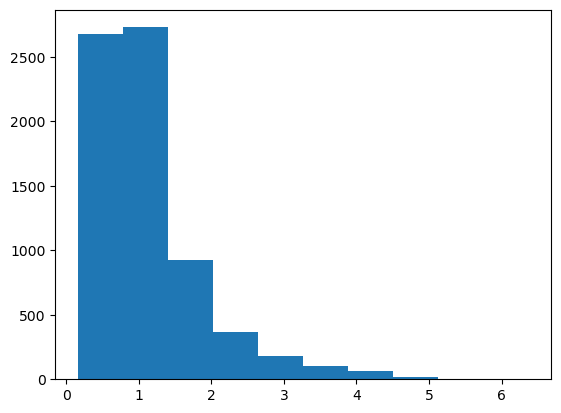

In [10]:
plt.hist(queries_metrics['tfidf_mean'])

In [15]:
get_mean_tfidf('who is aultman orrville', reader)

2.3063908956089096